Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.utils
from keras import utils as np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
%matplotlib inline

Reading Data and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv(r'/content/drive/MyDrive/IBM_Assignment_04/spam.csv', delimiter = ',', encoding = 'latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis = 1, inplace = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Label')

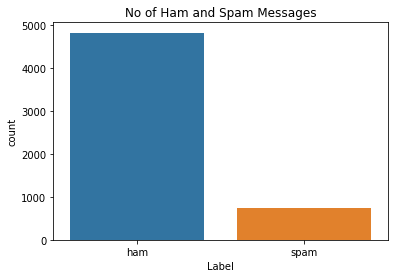

In [7]:
sns.countplot(data['v1'])
plt.title("No of Ham and Spam Messages")
plt.xlabel('Label')

Input and Output Vectors

In [8]:
X = data['v2']
Y = data['v1']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Splitting into Training and Testing Data

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state = 0,test_size = 0.25)

Processing the Data

In [10]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequence_matrix = pad_sequences(sequences,maxlen = max_len)

Creating Model and Adding Layers

In [11]:
def RNN():
  inputs = Input(name = 'inputs',shape = [max_len])
  layer = Embedding(max_words,50,input_length = max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256, name = 'FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1, name = 'out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs,layer)
  return model

Compiling the Model

In [12]:
model = RNN()
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Fitting the Model

In [13]:
model.fit(sequence_matrix,Y_train, batch_size = 128, epochs = 10, validation_split = 0.2, callbacks = [EarlyStopping(monitor = 'val_loss',min_delta = 0.0001)])

Epoch 1/10
27/27 [==============================] - 8s 33ms/step - loss: 0.3401 - accuracy: 0.8687 - val_loss: 0.3097 - val_accuracy: 0.8696
Epoch 2/10
27/27 [==============================] - 0s 13ms/step - loss: 0.1046 - accuracy: 0.9731 - val_loss: 0.1026 - val_accuracy: 0.9785


In [14]:
test_sequence = tok.texts_to_sequences(X_test)
test_sequence_matrix = keras.utils.data_utils.pad_sequences(test_sequence, maxlen = max_len)

Saving the Model

In [15]:
model.save('spam.h5')

Testing the Model

In [17]:
accur = model.evaluate(test_sequence_matrix, Y_test)

44/44 [==============================] - 0s 6ms/step - loss: 0.1217 - accuracy: 0.9713


In [18]:
print('The Accuracy of the model \n Loss:{:0.3f}\n  Accuracy:{:0.3f}, '.format(accur[0],accur[1]))

The Accuracy of the model 
 Loss:0.122
  Accuracy:0.971, 
